# Arctic Permafrost Modeling

ATS initially came out of a desire to model Arctic permafrost using the best available understanding of cryosphere processes, including subsurface flow in partially saturated, partially frozen soils.  These simulations form the basis for doing this work, and represent an approach designed for continuous permafrost.

This demo also is useful for seeing how layering works in ATS, as there are heterogeneous properties throughout (peat and mineral soil layers).

The basic spinup of this sequence is as follows:

* spinup0-water_table: Run a steady-state problem to establish a water table
* spinup1-freezeup: Freeze the steady-state water table from below, establishing a saturated ice table.
* spinup2-dynamic: Drive a simulation with an annual, cyclic steady-state meterological data, derived from DayMet but smoothed extensively to generate a climatologically "typical" year.  This establishes a permafrost vs active layer, reasonable saturation state, etc.

After these, many choices are available.  1D column runs could be run using the same input file as spinup2-dynamic and driven with real daily data.  2D or 3D runs on transects, hillslopes, or other geometries can have the result of spinup2-dynamic draped from the surface and lateral flow and spatial variations can be considered.  All of these use the same basic form of input file, with a differing mesh, so we simply demonstrate one, including snow distribution to capture variations in snowpack with topography.

In [17]:
%matplotlib inline
import sys,os

sys.path.append(os.path.join('/home/rk/ats_rk/amanzi/src/physics/ats/tools/utils'))

import os
cwd = os.getcwd()
cwd

'/home/rk/ats_rk/testing/ats-demos/rk_model'

In [1]:
%matplotlib inline
import sys,os

sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
#sys.path.append(os.path.join('/home/rk/ats_rk/amanzi/src/physics/ats/tools/utils'))
import ats_xdmf
import plot_column_data
import colors
import numpy as np
import matplotlib.cm
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'ats_xdmf'

In [22]:
import h5py
import pandas as pd

## spinup1: Freeze steady-state to generate ice column

Transient simulations are initialized in the winter to make spinup simpler.  Therefore we start from a fully frozen domain (instead of the partially frozen domain that would be required for starting any other time of year).  

To establish this fully-frozen domain, we freeze the hydrostatic water column from below until the solution reaches steady-state again.  This "pseudo-transient" approach is easier for solvers than solving the steady-state problem.  This is done in the subsurface only, solving coupled Richards and energy equations.

The bottom boundary temperature is set at -9 F, which is, according to deep borehole data, a reasonable temperature for deep permafrost in Barrow.  As the column freezes, water expands to form ice, pushing the water above it up.  This results in a careful balance -- we want to set the bottom pressure in spinup0 such that, when frozen, the ice table is near the surface, but not above it (which would break the problem here because a no flux condition is put on that top surface).  The calculation of such a pressure is difficult, as it depends upon soil properties, freezing rates, and other dynamic things, so a test-and-check approach is taken.

First, a bottom pressure is set for spinup0, then frozen from below in spinup1.  If the resulting ice table is too high, the pressure in the top cell will blow up, and the process is repeated with a smaller bottom pressure in spinup0.   If the resulting ice table is too low, the entire active layer will happen in an unsaturated zone, and the soil will never saturate.  Typically, for coastal polygonal permafrost, the soil is quite wet, so we work to get the ice table as close to the surface as possible.  More thought might be required for a drier condition, but remember that too wet is rarely an issue (things can drain over a few dynamic years fairly quickly as long as they thaw, but filling up from too dry takes a much longer time).  Bisection on the spinup0 bottom pressure can be used to quickly find a pressure that hits an appropriate ice table level.

NOTE: From here on, transient problems are plotted such that early times have low intensity colors, and late times are high intensity colors.

NOTE: This run takes some time (especially if the code is built in debug mode), ~10 minutes.

RuntimeError: Cannot load ATS XDMF h5 file at: spinup_test.demo/ats_vis_data.h5

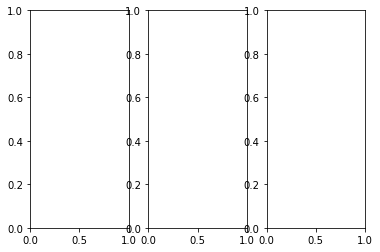

In [23]:
# plot the solution
directory = "spinup_test.demo"

#
# plot the solution
#
def plot(dirname, axs):
    """A generic plotting function that plots saturation as a function of depth."""

    plot_column_data.plot_subsurface(vis, ['pressure',], axs[0], cmap='jet')
    axs[0].set_xlabel('pressure [Pa]')
    ax.set_ylabel('z [m]')
    
    plot_column_data.plot_subsurface(vis, ['saturation_liquid',], axs[1], None, cmap='jet')
    axs[0].set_xlabel('saturation [-]')
    ax.set_ylabel('z [m]')

def plot(directory, axs, style):
    # load the data
    vis = ats_xdmf.VisFile(directory, time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["pressure", "pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"]])
    times = vis.times
    
    ice = colors.cm_mapper(-10, times[-1], colors.ice_cmap())
    water = colors.cm_mapper(-10, times[-1], colors.water_cmap())
    gas = colors.cm_mapper(-10, times[-1], colors.gas_cmap())    
    
    # plot saturation of liquid, pressure
    z = vis.centroids[:,2]
    for i,t in enumerate(times):
        label = False
        if i == len(times)-1:
            axs[0].plot(dati[2,i,:],z, style, color=water(t), label='liquid')
            axs[0].plot(dati[3,i,:],z, style, color=ice(t), label='ice')
            axs[0].plot(dati[4,i,:],z, style, color=gas(t), label='gas')
        else:
            axs[0].plot(dati[2,i,:],z, style, color=water(t))
            axs[0].plot(dati[3,i,:],z, style, color=ice(t))
            axs[0].plot(dati[4,i,:],z, style, color=gas(t))
        axs[2].plot(dati[5,i,:],z, style, color=gas(t))
        axs[1].plot(dati[1,i,:],z, style, color=water(t))
        axs[0].plot(dati[2,i,:],z, style, color=water(t))
        axs[0].plot(dati[3,i,:],z, style, color=ice(t))
        axs[0].plot(dati[4,i,:],z, style, color=gas(t))

def decorate(axs):
    axs[0].set_xlabel('saturation [-]')
    axs[0].set_ylabel('z-coordinate [m]')
    axs[1].set_xlabel('pressure [Pa]')
    axs[2].set_xlabel('temperature [K]')
    axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axs[0].set_xlim([-.1,1.1])
    axs[0].legend()


# full column
fig, axs = plt.subplots(1,3)
plot(directory, axs, '-')
decorate(axs)

# and a zoomed version
fig, axs = plt.subplots(1,3)
plot(directory, axs, '-')
decorate(axs)
axs[0].set_ylim([4.5,5])
axs[1].set_ylim([4.5,5])
axs[2].set_ylim([4.5,5])


plt.show()
            

In [9]:
file_name = 'spinup_test.demo'
input_filename = 'spin_test.xml'

In [10]:
# load the ATS solution
directory = f"./{file_name}/"
vis = ats_xdmf.VisFile(directory)
vis.loadMesh(columnar=True)

RuntimeError: Cannot load ATS XDMF h5 file at: ./spinup_test.demo/ats_vis_data.h5

### RK - work

#### The data files are stored in three seperate files:
1. Subsurface data - ats_vis_data.h5
2. Surface data - ats_vis_surface_data.h5
3. Snow data - ats_vis_snow_data.h5

In [14]:
### Extracting the subsurface data
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    porosity = hdf.get('base_porosity.cell.0')
    print(porosity)

OSError: Unable to open file (unable to open file: name = 'spinup_test.demo/ats_vis_data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [7]:
### Extracting the node information of the cells
# Extracted the the coordinates from paraview - have to think of a smarter way!

data_nodes = pd.read_csv('data/column_coord.csv')
data_nodes

# Points_2 - represents the dz 

,Points_0,Points_1,Points_2,Points_Magnitude,Point ID
0,0,0,5.00,5.0000,0
1,0,0,4.98,4.9800,1
2,0,0,4.96,4.9600,2
3,0,0,4.94,4.9400,3
4,0,0,4.92,4.9200,4
...,...,...,...,...,...
339,1,1,-27.00,27.0370,339
340,1,1,-29.00,29.0345,340
341,1,1,-31.00,31.0322,341
342,1,1,-33.00,33.0303,342


In [8]:
### Finding the average between two rows - to find centroidal distance

#z_1 = data_nodes['Points_2'][1:]
data_nodes['Points_2_a'] = data_nodes['Points_2'].shift(1,axis=0)
#z_1.append({'0':0},ignore_index=True)
data_nodes['Points_2_a'][0] = 0
data_nodes['dz'] = (data_nodes['Points_2'] + data_nodes['Points_2_a'])/2
data_nodes

<ipython-input-8-7ed70db12958>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nodes['Points_2_a'][0] = 0


,Points_0,Points_1,Points_2,Points_Magnitude,Point ID,Points_2_a,dz
0,0,0,5.00,5.0000,0,0.00,2.50
1,0,0,4.98,4.9800,1,5.00,4.99
2,0,0,4.96,4.9600,2,4.98,4.97
3,0,0,4.94,4.9400,3,4.96,4.95
4,0,0,4.92,4.9200,4,4.94,4.93
...,...,...,...,...,...,...,...
339,1,1,-27.00,27.0370,339,-25.00,-26.00
340,1,1,-29.00,29.0345,340,-27.00,-28.00
341,1,1,-31.00,31.0322,341,-29.00,-30.00
342,1,1,-33.00,33.0303,342,-31.00,-32.00


In [9]:
data_nodes['dz'][1:86]

1      4.99
2      4.97
3      4.95
4      4.93
5      4.91
      ...  
81   -26.00
82   -28.00
83   -30.00
84   -32.00
85   -34.00
Name: dz, Length: 85, dtype: float64

In [10]:
# Storing the dz coordinate
dz = data_nodes['Points_2'][:86]
dz

0      5.00
1      4.98
2      4.96
3      4.94
4      4.92
      ...  
81   -27.00
82   -29.00
83   -31.00
84   -33.00
85   -35.00
Name: Points_2, Length: 86, dtype: float64

In [11]:
def inputfiles_pddataframes(file_name,t):
    """
    The function is defined to read the input files from the ats simulation. 
    For each time instance, a dataframe can store the data.
 
    Parameters
    ------
    
    Input parameters:
    
    file_name : Provide the path to access the file name. 
    Ex: 'richards_steadystate.demo/ats_vis_data.h5'
    
    t : The time instance at which the data is required.
    Ex: cell_volume.cell.0/{t} - here 0/0 - signifies the first directory (with data at t=0), 
    similary 0/1 - signifies the second directory (with data at t=1).
            
    Output parameters:
    
    data_results : pandas dataframe with all the key elements of the simulation.
    
    - idea - can't we write a smart function that directly accesses all the columns? - !
    
    """
    
    with h5py.File(file_name,'r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0/{t}'))
        cell_volume = cell_volume_all.flatten()
        
        ### Extracting the node information of the cells
        # Extracted the the coordinates from paraview - have to think of a smarter way!
        data_nodes = pd.read_csv('data/column_coord.csv')
        
        # Storing the dz coordinates
        ### Finding the average between two rows - to find centroidal distance

        #z_1 = data_nodes['Points_2'][1:]
        data_nodes['Points_2_a'] = data_nodes['Points_2'].shift(1,axis=0)
        #z_1.append({'0':0},ignore_index=True)
        data_nodes['Points_2_a'][0] = 0
        data_nodes['dz'] = (data_nodes['Points_2'] + data_nodes['Points_2_a'])/2
        
        z = data_nodes['dz'][1:86]
        
        # Storing the variables/constants in a dataframe - Do we have a direct function to do this? 
        # Can we simplify the code?
        
        data_results = pd.DataFrame(index=z,data=cell_volume,columns=['cell_volume'])

        mass_density_all = np.array(hdf.get(f'mass_density_liquid.cell.0/{t}'))
        mass_density = mass_density_all.flatten()
        data_results['mass_density [rho_l] [kg m^{-3}]'] = mass_density



        molar_density_all = np.array(hdf.get(f'molar_density_liquid.cell.0/{t}'))
        molar_density = molar_density_all.flatten()
        data_results['molar_density [n_l] [mol m^{-3}]'] = molar_density


        permeability_all = np.array(hdf.get(f'permeability.cell.0/{t}'))
        permeability = permeability_all.flatten()
        data_results['Absolute permeability [K] (m^{2})'] = permeability



        porosity_all = np.array(hdf.get(f'porosity.cell.0/{t}'))
        porosity = porosity_all.flatten()
        data_results['Porosity [phi] (-)'] = porosity

        pressure_all = np.array(hdf.get(f'pressure.cell.0/{t}'))
        pressure = pressure_all.flatten()
        data_results['Abs pressure [p_abs] [Pa]'] = pressure 
        # Water pressure or total pressure (Atm + water)? - Probably both

        relative_permeability_all = np.array(hdf.get(f'relative_permeability.cell.0/{t}'))
        relative_permeability = relative_permeability_all.flatten()
        data_results['Relative permeability [kr] [-]'] = relative_permeability


        saturation_gas_all = np.array(hdf.get(f'saturation_gas.cell.0/{t}'))
        saturation_gas = saturation_gas_all.flatten()
        data_results['Saturation of gas [s_g] [-]'] = saturation_gas


        saturation_liquid_all = np.array(hdf.get(f'saturation_liquid.cell.0/{t}'))
        saturation_liquid = saturation_liquid_all.flatten()
        data_results['Saturation of liquid [s_l] [-]'] = saturation_liquid


        
        saturation_ice_all = np.array(hdf.get(f'saturation_ice.cell.0/{t}'))
        saturation_ice = saturation_ice_all.flatten()
        data_results['Saturation of ice [s_i] [-]'] = saturation_ice
        
        temperature_all = np.array(hdf.get(f'temperature.cell.0/{t}'))
        temperature = temperature_all.flatten()
        data_results['Temperature [T] [K]'] = temperature


        viscosity_liquid_all = np.array(hdf.get(f'viscosity_liquid.cell.0/{t}'))
        viscosity_liquid = viscosity_liquid_all.flatten()
        data_results['viscosity_liquid [v] Pas]'] = viscosity_liquid


        water_content_all = np.array(hdf.get(f'water_content.cell.0/{t}'))
        water_content = water_content_all.flatten()
        data_results['water_content [theta] mols'] = water_content
        
        return data_results

In [12]:
# Determining the time instances at which the data is stored

with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        print(time_period)
        # Time series stored in an irregular format! - 
        # ['0' '100' '103' '104' '105' '106' '107' '108' '109' '110' '111']

[   0  100 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900  200  300
  400  500  600  700  800  900]


### Storing the data for all time instances

In [13]:
for i in time_period:
    # https://stackoverflow.com/questions/1060090/changing-variable-names-with-python-for-loops
    locals()["data_results_"+str(i)] = inputfiles_pddataframes(file_name=f'{file_name}/ats_vis_data.h5', t=i)

<ipython-input-11-369e9da2dc54>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nodes['Points_2_a'][0] = 0


### Plotting the initial pressure:

In [14]:
data_results_0['Abs pressure [p_abs] [Pa]']

dz
 4.99      -6450.0835
 4.97      -6253.9505
 4.95      -6057.8175
 4.93      -5861.6845
 4.91      -5665.5515
             ...     
-26.00    297458.0000
-28.00    317071.3000
-30.00    336684.6000
-32.00    356297.9000
-34.00    375911.2000
Name: Abs pressure [p_abs] [Pa], Length: 85, dtype: float64

In [15]:
rho_avg = 1000 # kg m^{-3} - Provided by the developer 
g = 9.8006 # ms^{-2} - Provided by the user, g = (0,0,-9.8006m ms^{-2})
p_0 = 101325 # Pa

# Calculating the water pressure = p_abs -p_0
data_results_0['Water pressure [p_l] [Pa]'] = data_results_0['Abs pressure [p_abs] [Pa]'] - p_0

data_results_0['Pressure head [m]'] = data_results_0['Water pressure [p_l] [Pa]']/(rho_avg*g)

data_results_0['Elevation head [m]'] = data_results_0.index

data_results_0['Hydraulic head [m]'] = data_results_0['Pressure head [m]'] + data_results_0['Elevation head [m]']

data_results_0['Atmospheric pressure head [m]'] = 101325/(rho_avg*g)

data_results_0

,cell_volume,mass_density [rho_l] [kg m^{-3}],molar_density [n_l] [mol m^{-3}],Absolute permeability [K] (m^{2}),Porosity [phi] (-),Abs pressure [p_abs] [Pa],Relative permeability [kr] [-],Saturation of gas [s_g] [-],Saturation of liquid [s_l] [-],Saturation of ice [s_i] [-],Temperature [T] [K],viscosity_liquid [v] Pas],water_content [theta] mols,Water pressure [p_l] [Pa],Pressure head [m],Elevation head [m],Hydraulic head [m],Atmospheric pressure head [m]
dz,,,,,,,,,,,,,,,,,,
4.99,0.02,999.933993,55504.709505,5.000000e-11,0.850000,-6450.0835,0.000002,0.749568,0.250432,0.0,273.65,0.001753,236.302386,-107775.0835,-10.996784,4.99,-6.006784,10.338653
4.97,0.02,999.933993,55504.709505,5.000000e-11,0.850000,-6253.9505,0.000002,0.749426,0.250574,0.0,273.65,0.001753,236.436258,-107578.9505,-10.976772,4.97,-6.006772,10.338653
4.95,0.02,999.933993,55504.709505,5.000000e-11,0.850000,-6057.8175,0.000002,0.749284,0.250716,0.0,273.65,0.001753,236.570468,-107382.8175,-10.956760,4.95,-6.006760,10.338653
4.93,0.02,999.933993,55504.709505,5.000000e-11,0.850000,-5861.6845,0.000002,0.749142,0.250858,0.0,273.65,0.001753,236.705018,-107186.6845,-10.936747,4.93,-6.006747,10.338653
4.91,0.02,999.933993,55504.709505,5.000000e-11,0.850000,-5665.5515,0.000002,0.748999,0.251001,0.0,273.65,0.001753,236.839909,-106990.5515,-10.916735,4.91,-6.006735,10.338653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-26.00,2.00,1000.032053,55510.152654,2.000000e-13,0.501956,297458.0000,3.165679,0.000000,1.000000,0.0,273.65,0.001753,55727.345008,196133.0000,20.012346,-26.00,-5.987654,10.338653
-28.00,2.00,1000.041859,55510.696969,2.000000e-13,0.502152,317071.3000,3.165710,0.000000,1.000000,0.0,273.65,0.001753,55749.666412,215746.3000,22.013581,-28.00,-5.986419,10.338653
-30.00,2.00,1000.051665,55511.241284,2.000000e-13,0.502349,336684.6000,3.165741,0.000000,1.000000,0.0,273.65,0.001753,55771.988243,235359.6000,24.014815,-30.00,-5.985185,10.338653


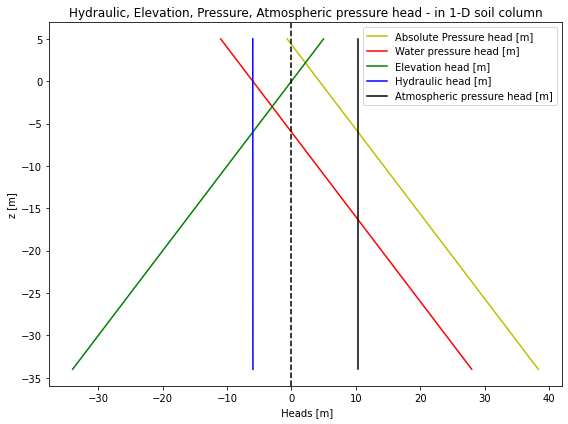

In [16]:
# To find the elevation where -ve pressure head begins
#z_drop = data_results_0[data_results_0['Pressure head [m]'].le(0)].index[0]

z = data_results_0.index

fig = plt.figure(figsize=(8,6))

plt.title('Hydraulic, Elevation, Pressure, Atmospheric pressure head - in 1-D soil column')
plt.plot(data_results_0['Abs pressure [p_abs] [Pa]']/(rho_avg*g), z, 'y', label='Absolute Pressure head [m]')
plt.plot(data_results_0['Pressure head [m]'], z, 'r', label='Water pressure head [m]')
plt.plot(data_results_0['Elevation head [m]'], z, 'g', label='Elevation head [m]')
plt.plot(data_results_0['Hydraulic head [m]'], z, 'b', label='Hydraulic head [m]')
plt.plot(data_results_0['Atmospheric pressure head [m]'], z, 'k', label='Atmospheric pressure head [m]')
plt.axvline(x=0,color='k',linestyle='--')
plt.ylabel('z [m]')
plt.xlabel(' Heads [m]')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
data_results_0.columns

Index(['cell_volume', 'mass_density [rho_l] [kg m^{-3}]',
       'molar_density [n_l] [mol m^{-3}]', 'Absolute permeability [K] (m^{2})',
       'Porosity [phi] (-)', 'Abs pressure [p_abs] [Pa]',
       'Relative permeability [kr] [-]', 'Saturation of gas [s_g] [-]',
       'Saturation of liquid [s_l] [-]', 'Saturation of ice [s_i] [-]',
       'Temperature [T] [K]', 'viscosity_liquid [v] Pas]',
       'water_content [theta] mols', 'Water pressure [p_l] [Pa]',
       'Pressure head [m]', 'Elevation head [m]', 'Hydraulic head [m]',
       'Atmospheric pressure head [m]'],
      dtype='object')

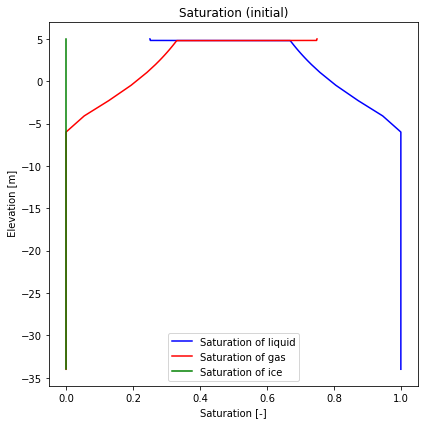

In [20]:
fig = plt.figure(figsize=(6,6))

plt.title('Saturation (initial)')
plt.plot(data_results_0['Saturation of liquid [s_l] [-]'], z, 'b', label='Saturation of liquid')
plt.plot(data_results_0['Saturation of gas [s_g] [-]'], z, 'r', label='Saturation of gas')
plt.plot(data_results_0['Saturation of ice [s_i] [-]'], z, 'g', label='Saturation of ice')

plt.xlabel('Saturation [-]')
plt.ylabel(' Elevation [m]')
plt.tight_layout()
plt.legend()
#plt.show()

In [38]:
data_results_0.columns

Index(['cell_volume', 'mass_density [rho_l] [kg m^{-3}]',
       'molar_density [n_l] [mol m^{-3}]', 'Absolute permeability [K] (m^{2})',
       'Porosity [phi] (-)', 'Abs pressure [p_abs] [Pa]',
       'Relative permeability [kr] [-]', 'Saturation of gas [s_g] [-]',
       'Saturation of liquid [s_l] [-]', 'Saturation of ice [s_i] [-]',
       'Temperature [T] [K]', 'viscosity_liquid [v] Pas]',
       'water_content [theta] mols', 'Water pressure [p_l] [Pa]',
       'Pressure head [m]', 'Elevation head [m]', 'Hydraulic head [m]',
       'Atmospheric pressure head [m]'],
      dtype='object')

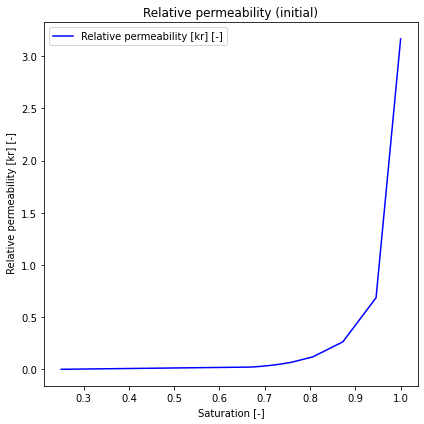

In [41]:
fig = plt.figure(figsize=(6,6))

plt.title('Relative permeability (initial)')
plt.plot(data_results_0['Saturation of liquid [s_l] [-]'],data_results_0['Relative permeability [kr] [-]'], 'b', label='Relative permeability [kr] [-]')

plt.xlabel('Saturation [-]')
plt.ylabel(' Relative permeability [kr] [-]')
plt.tight_layout()
plt.legend()
#plt.show()

In [21]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        print(time_period)

[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900]


In [22]:
len(time_period)

20

In [23]:
time_period[1:]

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900])

### Defining a dataframe that extracts the data for a single variable for all time instances

In [24]:
def input_datavar(file_name, variable):
    """
    The function defined to extract a variable across all time instances.
    
    Parameters
    ------
    
    Input parameters:
    
    file_name : Provide the path to access the file name. 
    Ex: 'richards_steadystate.demo/ats_vis_data.h5'
    
    variable: Name of the variable in the dataset that you are interested in.
    Ex: 'cell_volume'
    
    Output parameters:
    
    data_var : pandas dataframe with the time series data of the variable.
    
    """
    
    # Storing the dz coordinates
    ### Finding the average between two rows - to find centroidal distance

    #z_1 = data_nodes['Points_2'][1:]
    data_nodes['Points_2_a'] = data_nodes['Points_2'].shift(1,axis=0)
    #z_1.append({'0':0},ignore_index=True)
    data_nodes['Points_2_a'][0] = 0
    data_nodes['dz'] = (data_nodes['Points_2'] + data_nodes['Points_2_a'])/2
        
    z = data_nodes['dz'][1:86]
    
    # To determine the time period and the list in which the dataframes 
    
    with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
    
    with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        var_all_0 = np.array(hdf.get(f'{variable}.cell.0/0'))
        var_0 = var_all_0.flatten()
        data_var = pd.DataFrame(index=z,data=var_0,columns=[f'0'])
        
        for i in time_period[1:]:
            var_all = np.array(hdf.get(f'{variable}.cell.0/{i}'))
            var = var_all.flatten()
            
            data_var[f'{i}'] = var
    
    return data_var

In [25]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    porosity = hdf.get('saturation_liquid.cell.0/100')
    print(porosity)

List of datasets in this file: 
 
 ['base_porosity.cell.0', 'capillary_pressure_gas_liq.cell.0', 'capillary_pressure_liq_ice.cell.0', 'cell_volume.cell.0', 'darcy_velocity.cell.0', 'darcy_velocity.cell.1', 'darcy_velocity.cell.2', 'density_rock.cell.0', 'dwater_content|dtemperature.cell.0', 'energy.cell.0', 'enthalpy.cell.0', 'enthalpy_times_relative_permeability.cell.0', 'internal_energy_ice.cell.0', 'internal_energy_liquid.cell.0', 'internal_energy_rock.cell.0', 'mass_density_liquid.cell.0', 'molar_density_ice.cell.0', 'molar_density_liquid.cell.0', 'permeability.cell.0', 'porosity.cell.0', 'pressure.cell.0', 'relative_permeability.cell.0', 'saturation_gas.cell.0', 'saturation_ice.cell.0', 'saturation_liquid.cell.0', 'temperature.cell.0', 'thermal_conductivity.cell.0', 'viscosity_liquid.cell.0', 'water_content.cell.0']


<HDF5 dataset "100": shape (85, 1), type "<f8">


In [26]:
### Accessing the variable at all time instances

### Add or remove variable name if required
variables = ['saturation_liquid','saturation_ice','saturation_gas','pressure','relative_permeability','temperature']

for i in variables:
    locals()["df_"+str(i)] = input_datavar(file_name, i)
    len_rows = len(locals()["df_"+str(i)].columns)
    locals()["df_"+str(i)].columns = np.arange(0,len_rows,1)

<ipython-input-24-3a64ce11441b>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nodes['Points_2_a'][0] = 0


In [27]:
df_pressure.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dz,,,,,,,,,,,,,,,,,,,,
4.99,-6450.0835,5185.331807,11727.927904,18435.774849,23027.768632,27603.780109,31847.747226,38379.893564,44806.932685,51168.028686,56417.588995,61294.154528,65554.975819,70192.114091,74833.120580,83910.502544,-7383.947558,-21294.263287,-23137.652994,-23416.506747
4.97,-6253.9505,5381.697777,11924.245253,18631.990433,23224.024183,27800.032488,32043.987343,38576.111323,45003.111332,51364.208447,56613.757935,61490.328426,65751.145118,70388.274946,75029.277658,84106.644890,-5530.171789,-19164.789816,-20974.293377,-21252.354783
4.95,-6057.8175,5578.307565,12120.758622,18828.302066,23420.415915,27996.418236,32240.348784,38772.428272,45199.350571,51560.449797,56809.977778,61686.557978,65947.365471,70584.478476,75225.473561,84302.811402,-2476.451804,-15649.986513,-17398.230994,-17667.481233
4.93,-5861.6845,5775.159106,12317.466109,19024.708675,23616.942269,28192.935725,32436.829977,38968.842987,45395.649435,51756.751629,57006.247500,61882.841927,66143.635589,70780.723440,75421.706962,84499.000821,1705.345235,-10838.469155,-12501.972982,-12757.330123
4.91,-5665.5515,5972.250443,12514.365851,19221.209180,23813.601700,28389.583334,32633.429357,39165.354050,45592.006966,51953.112844,57202.566085,62079.179028,66339.954194,70977.008614,75617.976552,84695.211914,7093.147602,-4644.693486,-6199.081270,-6435.465606


In [28]:
pressure_head_data = df_pressure/(10000)

In [29]:
pressure_head_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dz,,,,,,,,,,,,,,,,,,,,
4.99,-0.645008,0.518533,1.172793,1.843577,2.302777,2.760378,3.184775,3.837989,4.480693,5.116803,5.641759,6.129415,6.555498,7.019211,7.483312,8.391050,-0.738395,-2.129426,-2.313765,-2.341651
4.97,-0.625395,0.538170,1.192425,1.863199,2.322402,2.780003,3.204399,3.857611,4.500311,5.136421,5.661376,6.149033,6.575115,7.038827,7.502928,8.410664,-0.553017,-1.916479,-2.097429,-2.125235
4.95,-0.605782,0.557831,1.212076,1.882830,2.342042,2.799642,3.224035,3.877243,4.519935,5.156045,5.680998,6.168656,6.594737,7.058448,7.522547,8.430281,-0.247645,-1.564999,-1.739823,-1.766748
4.93,-0.586168,0.577516,1.231747,1.902471,2.361694,2.819294,3.243683,3.896884,4.539565,5.175675,5.700625,6.188284,6.614364,7.078072,7.542171,8.449900,0.170535,-1.083847,-1.250197,-1.275733
4.91,-0.566555,0.597225,1.251437,1.922121,2.381360,2.838958,3.263343,3.916535,4.559201,5.195311,5.720257,6.207918,6.633995,7.097701,7.561798,8.469521,0.709315,-0.464469,-0.619908,-0.643547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-26.00,29.745800,30.933762,99.541470,103.220643,104.610301,105.249878,105.585277,105.942160,106.174407,106.334161,106.436098,106.513623,106.560699,106.606545,106.638413,106.689669,107.296855,107.657513,107.709044,107.717581
-28.00,31.707130,101.587292,109.769959,111.384581,112.062265,112.418563,112.612819,112.829512,112.973567,113.074934,113.140865,113.191398,113.222328,113.252945,113.274146,113.308563,113.732028,114.005825,114.046405,114.053554
-30.00,33.668460,117.762746,120.325593,121.042310,121.367389,121.556111,121.662661,121.786273,121.870266,121.930577,121.970480,122.001313,122.020360,122.039438,122.052662,122.074281,122.348431,122.539799,122.569717,122.576086


Text(0.5, 0, 'Saturation (-)')

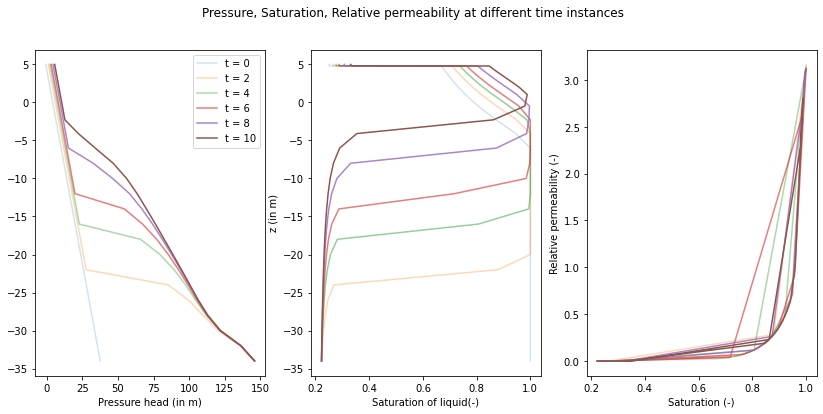

In [42]:
fig, (ax2, ax1, ax3) = plt.subplots(1, 3)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation, Relative permeability at different time instances')

z = df_saturation_liquid.index

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[2], z, alpha=0.3)
ax1.plot(df_saturation_liquid[4], z, alpha=0.5)
ax1.plot(df_saturation_liquid[6], z, alpha=0.6)
ax1.plot(df_saturation_liquid[8], z, alpha=0.8)
ax1.plot(df_saturation_liquid[10], z, alpha=1)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()
ax1.set_ylabel('z (in m)')
ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2, label ='t = 0')
ax2.plot(pressure_head_data[2], z, alpha=0.3, label ='t = 2')
ax2.plot(pressure_head_data[4], z, alpha=0.4, label ='t = 4')
ax2.plot(pressure_head_data[6], z, alpha=0.6, label ='t = 6')
ax2.plot(pressure_head_data[8], z, alpha=0.8, label ='t = 8')
ax2.plot(pressure_head_data[10], z, alpha=1, label ='t = 10')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.legend()

ax3.plot(df_saturation_liquid[0], df_relative_permeability[0], alpha=0.2)
ax3.plot(df_saturation_liquid[2], df_relative_permeability[2], alpha=0.3)
ax3.plot(df_saturation_liquid[4], df_relative_permeability[4], alpha=0.4)
ax3.plot(df_saturation_liquid[6], df_relative_permeability[6], alpha=0.6)
ax3.plot(df_saturation_liquid[8], df_relative_permeability[8], alpha=0.8)
ax3.plot(df_saturation_liquid[10], df_relative_permeability[10], alpha=1)
#ax3.plot(df_saturation_liquid[200], df_relative_permeability[200], alpha=1, label ='t = 2 days')
#ax3.legend()
ax3.set_ylabel('Relative permeability (-)')
ax3.set_xlabel('Saturation (-)')


Text(0.5, 0, 'Saturation (-)')

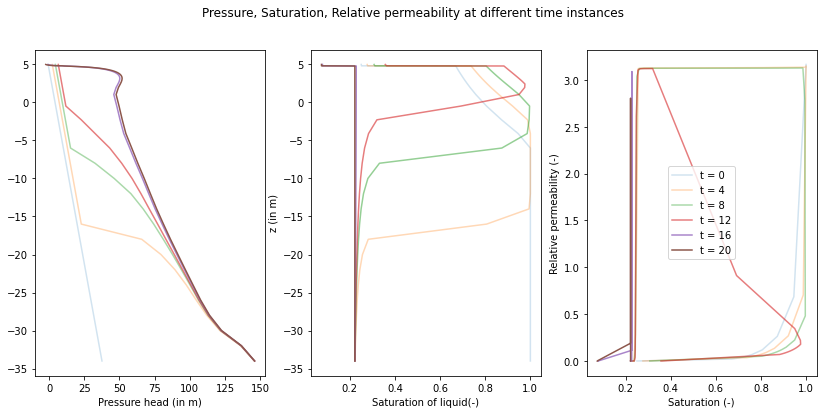

In [35]:
fig, (ax2, ax1, ax3) = plt.subplots(1, 3)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation, Relative permeability at different time instances')

z = df_saturation_liquid.index

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[4], z, alpha=0.3)
ax1.plot(df_saturation_liquid[8], z, alpha=0.5)
ax1.plot(df_saturation_liquid[12], z, alpha=0.6)
ax1.plot(df_saturation_liquid[16], z, alpha=0.8)
ax1.plot(df_saturation_liquid[19], z, alpha=1)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()
ax1.set_ylabel('z (in m)')
ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2)
ax2.plot(pressure_head_data[4], z, alpha=0.3)
ax2.plot(pressure_head_data[8], z, alpha=0.4)
ax2.plot(pressure_head_data[12], z, alpha=0.6)
ax2.plot(pressure_head_data[16], z, alpha=0.8)
ax2.plot(pressure_head_data[19], z, alpha=1)
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
#ax2.legend()

ax3.plot(df_saturation_liquid[0], df_relative_permeability[0], alpha=0.2, label ='t = 0')
ax3.plot(df_saturation_liquid[4], df_relative_permeability[2], alpha=0.3, label ='t = 4')
ax3.plot(df_saturation_liquid[8], df_relative_permeability[4], alpha=0.4, label ='t = 8')
ax3.plot(df_saturation_liquid[12], df_relative_permeability[6], alpha=0.6, label ='t = 12')
ax3.plot(df_saturation_liquid[16], df_relative_permeability[8], alpha=0.8, label ='t = 16')
ax3.plot(df_saturation_liquid[19], df_relative_permeability[10], alpha=1, label ='t = 20')
#ax3.plot(df_saturation_liquid[200], df_relative_permeability[200], alpha=1, label ='t = 2 days')
ax3.legend()
ax3.set_ylabel('Relative permeability (-)')
ax3.set_xlabel('Saturation (-)')

Text(0.5, 0, 'Temperature (K)')

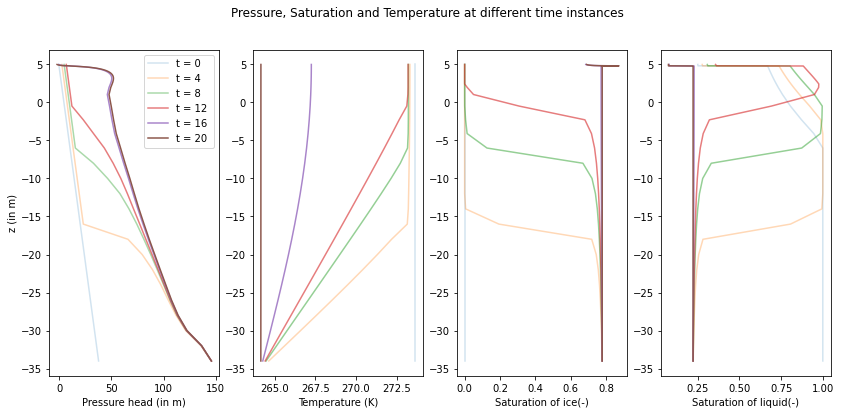

In [36]:
fig, (ax2, ax4, ax3,ax1) = plt.subplots(1, 4)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation and Temperature at different time instances')

z = df_saturation_liquid.index

#df_saturation_liquid = df_saturation_liquid.iloc[::-1]

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[4], z, alpha=0.3)
ax1.plot(df_saturation_liquid[8], z, alpha=0.5)
ax1.plot(df_saturation_liquid[12], z, alpha=0.6)
ax1.plot(df_saturation_liquid[16], z, alpha=0.8)
ax1.plot(df_saturation_liquid[19], z, alpha=1)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()

ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2, label ='t = 0')
ax2.plot(pressure_head_data[4], z, alpha=0.3, label ='t = 4 ')
ax2.plot(pressure_head_data[8], z, alpha=0.4, label ='t = 8 ')
ax2.plot(pressure_head_data[12], z, alpha=0.6, label ='t = 12 ')
ax2.plot(pressure_head_data[16], z, alpha=0.8, label ='t = 16 ')
ax2.plot(pressure_head_data[19], z, alpha=1, label ='t = 20 ')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.set_ylabel('z (in m)')
ax2.legend()

ax3.plot(df_saturation_ice[0], z, alpha=0.2)
ax3.plot(df_saturation_ice[4], z, alpha=0.3)
ax3.plot(df_saturation_ice[8], z, alpha=0.5)
ax3.plot(df_saturation_ice[12], z, alpha=0.6)
ax3.plot(df_saturation_ice[16], z, alpha=0.8)
ax3.plot(df_saturation_ice[19], z, alpha=1)
#ax1.plot(df_saturation_ice[200], z, alpha=1)
#ax1.legend()
#ax3.set_ylabel('z (in m)')
ax3.set_xlabel('Saturation of ice(-)')

ax4.plot(df_temperature[0], z, alpha=0.2)
ax4.plot(df_temperature[4], z, alpha=0.3)
ax4.plot(df_temperature[8], z, alpha=0.5)
ax4.plot(df_temperature[12], z, alpha=0.6)
ax4.plot(df_temperature[16], z, alpha=0.8)
ax4.plot(df_temperature[19], z, alpha=1)
#ax1.plot(df_temperature[200], z, alpha=1)
#ax1.legend()
#ax4.set_ylabel('z (in m)')
ax4.set_xlabel('Temperature (K)')

* Q - Why does pressure increase to a large extent when liquid freezes to ice? - Density of ice and water are 0.9167–0.9168 g/cm3 and  0.9998–0.999863 g/cm3 - Change in temperature 
* https://courses.lumenlearning.com/cheminter/chapter/phase-diagram-for-water/ - Read this link!

Text(0.5, 0, 'Temperature (K)')

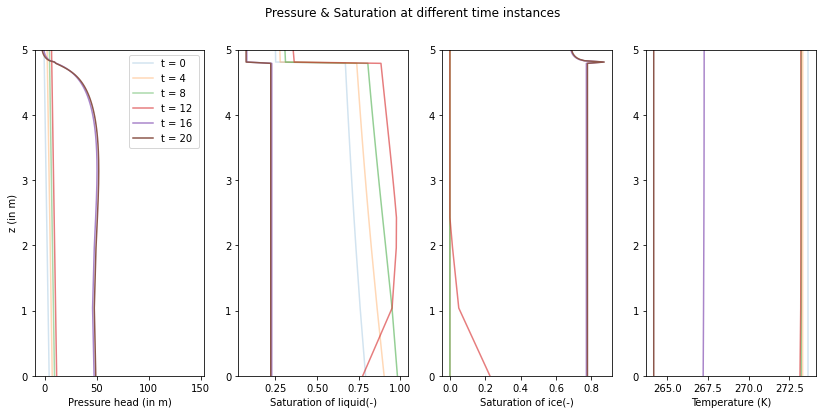

In [108]:
fig, (ax2, ax1, ax3,ax4) = plt.subplots(1, 4)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure & Saturation at different time instances')

z = df_saturation_liquid.index

#df_saturation_liquid = df_saturation_liquid.iloc[::-1]

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[4], z, alpha=0.3)
ax1.plot(df_saturation_liquid[8], z, alpha=0.5)
ax1.plot(df_saturation_liquid[12], z, alpha=0.6)
ax1.plot(df_saturation_liquid[16], z, alpha=0.8)
ax1.plot(df_saturation_liquid[19], z, alpha=1)
ax1.set_ylim(0,5)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()

ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2, label ='t = 0')
ax2.plot(pressure_head_data[4], z, alpha=0.3, label ='t = 4 ')
ax2.plot(pressure_head_data[8], z, alpha=0.4, label ='t = 8 ')
ax2.plot(pressure_head_data[12], z, alpha=0.6, label ='t = 12 ')
ax2.plot(pressure_head_data[16], z, alpha=0.8, label ='t = 16 ')
ax2.plot(pressure_head_data[19], z, alpha=1, label ='t = 20 ')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.set_ylabel('z (in m)')
ax2.set_ylim(0,5)
ax2.legend()

ax3.plot(df_saturation_ice[0], z, alpha=0.2)
ax3.plot(df_saturation_ice[4], z, alpha=0.3)
ax3.plot(df_saturation_ice[8], z, alpha=0.5)
ax3.plot(df_saturation_ice[12], z, alpha=0.6)
ax3.plot(df_saturation_ice[16], z, alpha=0.8)
ax3.plot(df_saturation_ice[19], z, alpha=1)
#ax1.plot(df_saturation_ice[200], z, alpha=1)
#ax1.legend()
#ax3.set_ylabel('z (in m)')
ax3.set_ylim(0,5)
ax3.set_xlabel('Saturation of ice(-)')

ax4.plot(df_temperature[0], z, alpha=0.2)
ax4.plot(df_temperature[4], z, alpha=0.3)
ax4.plot(df_temperature[8], z, alpha=0.5)
ax4.plot(df_temperature[12], z, alpha=0.6)
ax4.plot(df_temperature[16], z, alpha=0.8)
ax4.plot(df_temperature[19], z, alpha=1)
#ax1.plot(df_temperature[200], z, alpha=1)
#ax1.legend()
#ax4.set_ylabel('z (in m)')
ax4.set_ylim(0,5)
ax4.set_xlabel('Temperature (K)')

In [ ]:
### Plot along with material properties! - Plot Relative permeability